In [1]:
#====================#
# Block 0: Import Libraries and Define Directories
# This section imports necessary Python libraries for data processing, geospatial analysis, and visualization.
# It also defines directory paths for input data (watershed maps, observation CSVs, class mappings) and output (conductivity maps).
# The list of CSV files is initialized to process species observation data.

import os
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from rasterio.mask import mask
from shapely.geometry import box
from matplotlib.colors import LinearSegmentedColormap
from rasterio.plot import show

# Define directories
WATERSHEDS_DIR = "/home/ravl/.maps/Landuse/Watersheds"  # Directory containing watershed land use maps
OBS_DIR = "/home/ravl/.csvs/inaturalist"  # Directory containing species observation CSVs
OUTPUT_DIR = "/home/ravl/.maps/Conductivity"  # Directory to save conductivity maps
ORIGINAL_MAP_DIR = "/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled"  # Directory for São Lourenço 2023 map
ORIGINAL_CLASS_CSV = "/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/MPB_SAO_LOURENCO.csv"  # Class mapping CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Create output directory if it doesn't exist

# Get list of CSV files in the observation directory
csv_files = [f for f in os.listdir(OBS_DIR) if f.endswith('.csv')]

In [2]:
# Block: Composite Multiple Watershed Maps (Fix for Overlapping Bounding Boxes)
# This block should be inserted AFTER Block 0 (imports) and BEFORE the current integrating folder block
# or can REPLACE the current integrating folder block if you want a cleaner implementation

import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds

def composite_watershed_maps(directory, year, output_path):
    """
    Composite multiple watershed maps for a given year, handling overlapping bounding boxes
    where class=0 (background) values should not override valid data.
    
    Parameters:
    - directory: Directory containing watershed folders
    - year: Year to process
    - output_path: Path to save the composite map
    
    Returns:
    - composite_path: Path to the saved composite map
    """
    # Find all TIF files for the given year
    map_paths = []
    watershed_folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    
    for watershed in watershed_folders:
        map_dir = os.path.join(directory, watershed, 'DATA')
        if os.path.exists(map_dir):
            for file in os.listdir(map_dir):
                if file.endswith('.tif') and str(year) in file:
                    base = file[:-4]
                    if len(base) >= 4 and base[-4:].isdigit() and int(base[-4:]) == year:
                        map_paths.append(os.path.join(map_dir, file))
    
    if not map_paths:
        print(f"No maps found for year {year}")
        return None
    
    # Determine the overall extent and resolution
    lefts, rights, bottoms, tops = [], [], [], []
    res_x, res_y = [], []
    
    # First pass: collect spatial information
    for path in map_paths:
        with rasterio.open(path) as src:
            bounds = src.bounds
            lefts.append(bounds.left)
            rights.append(bounds.right)
            bottoms.append(bounds.bottom)
            tops.append(bounds.top)
            res_x.append(src.res[0])
            res_y.append(src.res[1])
    
    # Calculate the union extent
    min_left = min(lefts)
    max_right = max(rights)
    min_bottom = min(bottoms)
    max_top = max(tops)
    
    # Use the finest resolution
    resolution_x = min(res_x)
    resolution_y = min(res_y)
    
    # Calculate dimensions
    width = int((max_right - min_left) / resolution_x)
    height = int((max_top - min_bottom) / resolution_y)
    
    # Create transform for the composite
    transform = from_bounds(min_left, min_bottom, max_right, max_top, width, height)
    
    # Initialize composite array with zeros (background)
    composite = np.zeros((height, width), dtype=np.uint8)
    
    # Get CRS from the first map
    with rasterio.open(map_paths[0]) as ref:
        dst_crs = ref.crs
    
    # Process each map and composite them
    for idx, path in enumerate(map_paths):
        print(f"Processing {os.path.basename(path)} ({idx+1}/{len(map_paths)})")
        
        with rasterio.open(path) as src:
            # Read the source array
            src_array = src.read(1)
            
            # Create array for reprojected data
            reprojected = np.zeros((height, width), dtype=src_array.dtype)
            
            # Reproject to the composite grid
            reproject(
                src_array,
                reprojected,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )
            
            # CRITICAL: Composite logic - only update where composite is background (0)
            # and the new data has valid values (not 0)
            mask = (composite == 0) & (reprojected != 0)
            composite[mask] = reprojected[mask]
            
            # Alternative approach: You could also use maximum value
            # composite = np.maximum(composite, reprojected)
            
            # Or give priority to non-zero values
            # composite = np.where(reprojected != 0, reprojected, composite)
    
    # Save the composite
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=composite.dtype,
        crs=dst_crs,
        transform=transform,
    ) as dst:
        dst.write(composite, 1)
    
    print(f"Composite saved to: {output_path}")
    return output_path

# Alternative implementation as a processing block for your existing code
def fix_overlapping_watersheds(map_paths, output_dir):
    """
    Alternative implementation that can be integrated into your existing workflow
    """
    # This would be inserted AFTER you've collected map_paths
    # and BEFORE you save the final composite
    
    print("Fixing overlapping watershed boundaries...")
    
    # Process year by year
    years = range(1985, 2024)
    
    for year in years:
        year_maps = []
        
        # Collect all maps for this year
        for watershed_folder in os.listdir(WATERSHEDS_DIR):
            if os.path.isdir(os.path.join(WATERSHEDS_DIR, watershed_folder)):
                map_dir = os.path.join(WATERSHEDS_DIR, watershed_folder, 'DATA')
                map_path = find_tif_file_for_year(map_dir, year)
                if map_path:
                    year_maps.append(map_path)
        
        if year_maps:
            # Process using the composite function
            output_path = os.path.join(output_dir, f"{year}.tif")
            composite_watershed_maps(WATERSHEDS_DIR, year, output_path)

# Usage example for the new block:
# This would replace or supplement your existing "INTEGRATING FOLDER" block
if __name__ == "__main__":
    WATERSHEDS_DIR = "/home/ravl/.maps/Landuse/Watersheds"
    OUTPUT_DIR = "/home/ravl/.maps/Landuse/Composite"
    
    # Process all years
    for year in range(1985, 2024):
        composite_watershed_maps(WATERSHEDS_DIR, year, 
                               os.path.join(OUTPUT_DIR, f"{year}.tif"))

Processing CUIA_1985.tif (1/2)
Processing 1985.tif (2/2)
Composite saved to: /home/ravl/.maps/Landuse/Composite/1985.tif
Processing PANT_1986.tif (1/3)
Processing CUIA_1986.tif (2/3)
Processing 1986.tif (3/3)
Composite saved to: /home/ravl/.maps/Landuse/Composite/1986.tif
Processing PANT_1987.tif (1/3)
Processing CUIA_1987.tif (2/3)
Processing 1987.tif (3/3)
Composite saved to: /home/ravl/.maps/Landuse/Composite/1987.tif
Processing PANT_1988.tif (1/3)
Processing CUIA_1988.tif (2/3)
Processing 1988.tif (3/3)
Composite saved to: /home/ravl/.maps/Landuse/Composite/1988.tif
Processing PANT_1989.tif (1/3)
Processing CUIA_1989.tif (2/3)
Processing 1989.tif (3/3)
Composite saved to: /home/ravl/.maps/Landuse/Composite/1989.tif
Processing PANT_1990.tif (1/3)
Processing CUIA_1990.tif (2/3)
Processing 1990.tif (3/3)
Composite saved to: /home/ravl/.maps/Landuse/Composite/1990.tif
Processing PANT_1991.tif (1/3)
Processing CUIA_1991.tif (2/3)
Processing 1991.tif (3/3)
Composite saved to: /home/ravl/

In [14]:
WATERSHEDS_DIR = output_dir

Overall longitude extent: [-58.48652337164128, -53.68898076527257]
Overall latitude extent: [-17.955615730509404, -15.449585582401177]


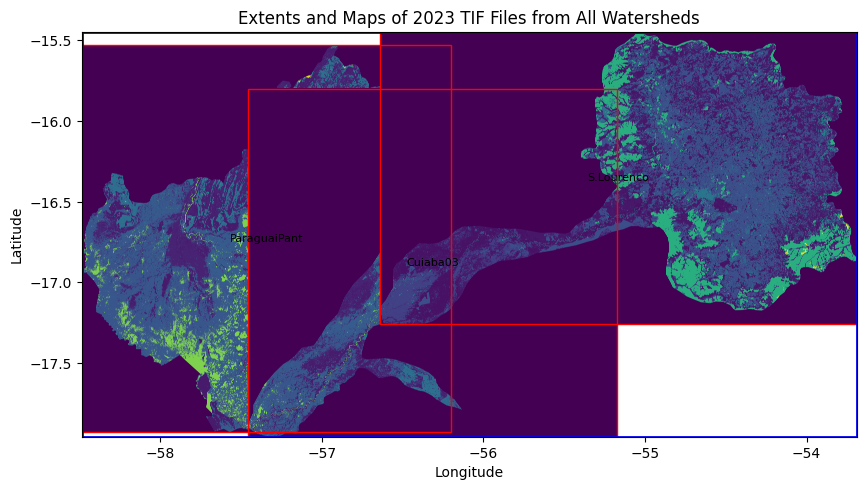

In [3]:
#Block 1: Define Mask and Bounds + Debug
# Function to find .tif file for a given year in a directory
def find_tif_file_for_year(directory, year):
    for file in os.listdir(directory):
        if file.endswith('.tif'):
            base = file[:-4]  # Remove '.tif'
            if len(base) >= 4 and base[-4:].isdigit() and int(base[-4:]) == year:
                return os.path.join(directory, file)
    return None

# Get list of watershed folders
watershed_folders = [f for f in os.listdir(WATERSHEDS_DIR) if os.path.isdir(os.path.join(WATERSHEDS_DIR, f))]

# Initialize lists
map_paths = []
lefts = []
bottoms = []
rights = []
tops = []
names = []

# Loop through each watershed folder
for watershed in watershed_folders:
    map_dir = os.path.join(WATERSHEDS_DIR, watershed, 'DATA')
    map_path = find_tif_file_for_year(map_dir, 2023)
    if map_path:
        with rasterio.open(map_path) as src:
            bounds = src.bounds
            map_paths.append(map_path)
            lefts.append(bounds.left)
            bottoms.append(bounds.bottom)
            rights.append(bounds.right)
            tops.append(bounds.top)
            names.append(watershed)
    else:
        print(f"No 2023 map found for {watershed}")

# Check if any maps were found
if map_paths:
    # Find overall min and max coordinates
    min_left = min(lefts)
    max_right = max(rights)
    min_bottom = min(bottoms)
    max_top = max(tops)
    print(f"Overall longitude extent: [{min_left}, {max_right}]")
    print(f"Overall latitude extent: [{min_bottom}, {max_top}]")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Set axis limits
    ax.set_xlim(min_left, max_right)
    ax.set_ylim(min_bottom, max_top)

    # Plot rasters
    for map_path in map_paths:
        with rasterio.open(map_path) as src:
            rasterio.plot.show(src, ax=ax, cmap='viridis')

    # Plot rectangles
    for left, bottom, right, top, name in zip(lefts, bottoms, rights, tops, names):
        rect = plt.Rectangle((left, bottom), right - left, top - bottom, fill=False, edgecolor='red')
        ax.add_patch(rect)
        # Calculate center for labeling
        center_x = (left + right) / 2
        center_y = (bottom + top) / 2
        ax.text(center_x, center_y, name, ha='center', va='center', fontsize=8)

    # Plot overall rectangle
    overall_rect = plt.Rectangle((min_left, min_bottom), max_right - min_left, max_top - min_bottom, fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(overall_rect)

    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Extents and Maps of 2023 TIF Files from All Watersheds')

    # Save the plot to a file
    plt.savefig('watershed_maps_and_extents_2023.png')
else:
    print("No 2023 TIF files found in any watershed directories.")

In [4]:
# Block 2: Load Class Information and 2023 Map
# This section loads the class mapping CSV to create a year-to-class-name dictionary.
# It also loads the 2023 São Lourenço land use map, which is used for generating the final conductivity maps.
# The watershed folders are listed to iterate over during observation collection.

# Load class info for original area (same classes apply to all watersheds)
class_df = pd.read_csv(ORIGINAL_CLASS_CSV)
class_df['year'] = class_df['band'].str.extract(r'(\d{4})').astype(int)
year_to_class_to_name = {
    year: dict(zip(group['class'], group['class_name']))
    for year, group in class_df.groupby('year')
}

# Get list of watershed folders
watershed_folders = [f for f in os.listdir(WATERSHEDS_DIR) if os.path.isdir(os.path.join(WATERSHEDS_DIR, f))]

# Load 2023 land use map for the original study area (for forecast)
original_map_path = os.path.join(ORIGINAL_MAP_DIR, '2023.tif')
with rasterio.open(original_map_path) as src:
    original_raster = src.read(1)  # Read the first band of the raster
    original_meta = src.meta.copy()  # Copy metadata for saving output rasters
    original_bounds = src.bounds  # Get spatial bounds for visualization
    original_transform = src.transform  # Get transform for coordinate mapping
    class_to_name_2023 = year_to_class_to_name[2023]  # Class mappings for 2023

# Initialize sum_raster for combined conductivity map
sum_raster = np.zeros_like(original_raster, dtype=np.float32)

with rasterio.open(original_map_path) as src:
    original_raster = src.read(1)
    unique, counts = np.unique(original_raster, return_counts=True)
    print(f"Unique classes: {unique}")
    print(f"Frequencies: {counts}")

Unique classes: [ 0  3  4  9 11 12 15 21 24 25 29 33 39 41 62]
Frequencies: [411951  62743  61544   2166   6902  14909  93754  29246   1519   1798
   3386   1519  40175   2838    295]


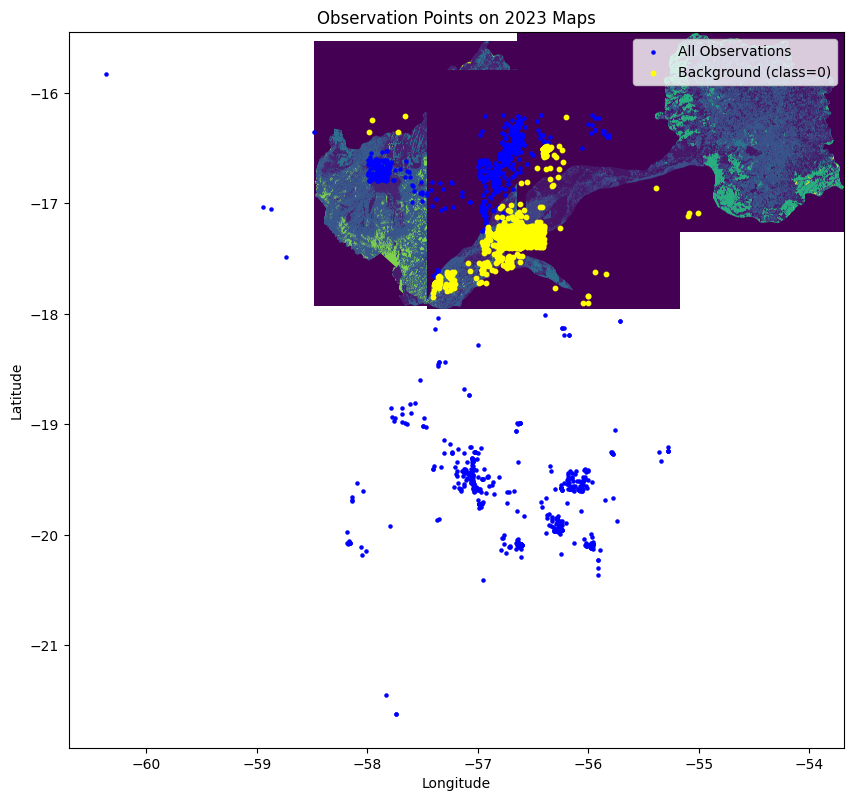

In [7]:
#Plots:


fig, ax = plt.subplots(figsize=(10, 10))

# Plot all 2023 maps
for watershed in watershed_folders:
    map_dir = os.path.join(WATERSHEDS_DIR, watershed, 'DATA')
    map_path = find_tif_file_for_year(map_dir, 2023)
    if map_path:
        with rasterio.open(map_path) as src:
            rasterio.plot.show(src, ax=ax, cmap='viridis')

# Plot all observations
all_obs = pd.concat([pd.read_csv(os.path.join(OBS_DIR, f))[['id', 'latitude', 'longitude', 'common_name']] for f in csv_files]).dropna()
ax.scatter(all_obs['longitude'], all_obs['latitude'], color='blue', label='All Observations', s=5)

# Plot not found points
if not_found_points:
    not_found_df = pd.DataFrame(not_found_points, columns=['id', 'latitude', 'longitude', 'common_name'])
    ax.scatter(not_found_df['longitude'], not_found_df['latitude'], color='red', label='Not Found', s=10)

# Plot background points
if background_points:
    background_df = pd.DataFrame(background_points, columns=['id', 'latitude', 'longitude', 'common_name'])
    ax.scatter(background_df['longitude'], background_df['latitude'], color='yellow', label='Background (class=0)', s=10)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Observation Points on 2023 Maps')
ax.legend()
plt.savefig('observation_points_2023.png')

In [6]:
# Block 3: Process Observations and Generate Conductivity Maps
# This section processes each species' observation CSV to calculate land use class probabilities.
# Observations are matched to watershed maps, ensuring each observation is counted only once using the first matching map.
# Probabilities are mapped to the 2023 São Lourenço map, normalized, and saved as individual species conductivity maps.
# The sum of normalized rasters is accumulated for the combined map.


# Initialize lists for debugging
not_found_points = []
background_points = []

# Process each species' observation data
for csv_file in csv_files:
    # Load observation data
    obs_df = pd.read_csv(os.path.join(OBS_DIR, csv_file))
    common_name = obs_df['common_name'].iloc[0]
    common_name_safe = common_name.replace(' ', '_').lower()
    
    # Preprocess observation data
    obs_df = obs_df[['id', 'observed_on', 'latitude', 'longitude']].dropna()
    obs_df['year'] = pd.to_numeric(obs_df['observed_on'].str[:4], errors='coerce')
    obs_df['year'] = obs_df['year'].ffill().bfill().astype(int)
    
    # Filter observations within overall extents (D(1) filter)
    obs_df = obs_df[(obs_df['latitude'] >= min_bottom) & (obs_df['latitude'] <= max_top) &
                    (obs_df['longitude'] >= min_left) & (obs_df['longitude'] <= max_right)]
    print(f"Filtered {len(obs_df)} observations for {common_name}")
    
    # Initialize list to store class names
    class_names = []
    
    # Process each observation
    for _, row in obs_df.iterrows():
        year = row['year']
        year_to_use = year if year in year_to_class_to_name else 2023
        class_to_name = year_to_class_to_name.get(year_to_use, class_to_name_2023)
        found = False
        for watershed in watershed_folders:
            map_dir = os.path.join(WATERSHEDS_DIR, watershed, 'DATA')
            map_path = find_tif_file_for_year(map_dir, year_to_use)
            if map_path is None or not os.path.exists(map_path):
                continue
            with rasterio.open(map_path) as src:
                raster = src.read(1)
                transform = src.transform
                row_idx, col = rasterio.transform.rowcol(transform, row['longitude'], row['latitude'])
                if 0 <= row_idx < raster.shape[0] and 0 <= col < raster.shape[1]:
                    class_val = raster[row_idx, col]
                    if class_val != 0:
                        class_name = class_to_name.get(class_val, 'unknown')
                        class_names.append(class_name)
                    else:
                        background_points.append((row['id'], row['latitude'], row['longitude'], common_name))
                    found = True
                    break
        if not found:
            not_found_points.append((row['id'], row['latitude'], row['longitude'], common_name))
            print(f"Observation {row['id']} not found in any map. Coordinates: latitude={row['latitude']}, longitude={row['longitude']}")
    
    # Calculate probability distribution
    total = len(class_names)
    probability_per_class_name = Counter(class_names)
    if total > 0:
        probability_per_class_name = {k: v / total for k, v in probability_per_class_name.items()}
    else:
        probability_per_class_name = {}
    print(f"Number of class names collected: {total}")
    print(f"Probabilities for {common_name}: {probability_per_class_name}")
    
    # Create conductivity map
    prob_list = np.array([probability_per_class_name.get(class_to_name_2023.get(i, 'unknown'), 0) for i in range(256)])
    
    conductivity_map = prob_list[original_raster]

        # Normalize the probability raster
    if np.max(conductivity_map) > 0:
        conductivity_map = conductivity_map / np.max(conductivity_map)
    else:
        print("Warning: All probabilities are zero; normalization skipped.")

    
    
    print(f"{common_name} conductivity_map min: {conductivity_map.min()}, max: {conductivity_map.max()}, mean: {conductivity_map.mean()}")
    # Save conductivity map
    output_path = os.path.join(OUTPUT_DIR, f"{common_name_safe}_conductivity.tif")
    meta = original_meta.copy()
    meta['dtype'] = 'float32'
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(conductivity_map.astype(np.float32), 1)
    
    # Update sum_raster for combined map
    sum_raster += conductivity_map


Filtered 1002 observations for Jaguar
Number of class names collected: 170
Probabilities for Jaguar: {'Savanna Formation': 0.38235294117647056, 'Grassland (Pastizal, Formación Herbácea)': 0.18823529411764706, 'River, Lake and Ocean': 0.041176470588235294, 'Wetland': 0.19411764705882353, 'Pasture': 0.08823529411764706, 'Forest Formation': 0.1, 'unknown': 0.0058823529411764705}
Jaguar conductivity_map min: 0.0, max: 1.0, mean: 0.15914969976501533
Filtered 499 observations for Giant Otter
Number of class names collected: 121
Probabilities for Giant Otter: {'Savanna Formation': 0.4049586776859504, 'Grassland (Pastizal, Formación Herbácea)': 0.32231404958677684, 'Forest Formation': 0.12396694214876033, 'Wetland': 0.09090909090909091, 'River, Lake and Ocean': 0.024793388429752067, 'Pasture': 0.024793388429752067, 'unknown': 0.008264462809917356}
Giant Otter conductivity_map min: 0.0, max: 1.0, mean: 0.14754373341521648
Filtered 472 observations for Crested Caracara
Number of class names coll

In [8]:
# Block 4: Save Combined Conductivity Map
# This section saves the combined conductivity map, which is the sum of all normalized species maps.
# The map is saved with the same metadata as the individual maps for consistency.

print(f"{common_name} conductivity_map min: {conductivity_map.min()}, max: {conductivity_map.max()}, mean: {conductivity_map.mean()}")
# Save combined conductivity map
combined_output_path = os.path.join(OUTPUT_DIR, 'combined_conductivity.tif')
with rasterio.open(combined_output_path, 'w', **original_meta) as dst:
    dst.write(sum_raster, 1)

Yacare Caiman conductivity_map min: 0.0, max: 1.0, mean: 0.17987741366464602


In [9]:
# Block 5: Compare Conductivity Maps
# This section computes the correlation between Jaguar and Giant Otter conductivity maps to verify if they differ after the fix.
# A correlation less than 1.0 indicates the maps are no longer identical, reflecting species-specific habitat preferences.

files = ['jaguar_conductivity.tif', 'giant_otter_conductivity.tif']
rasters = []
for f in files:
    with rasterio.open(os.path.join(OUTPUT_DIR, f)) as src:
        rasters.append(src.read(1))
print(f"Correlation between Jaguar and Otter: {np.corrcoef(rasters[0].flatten(), rasters[1].flatten())[0,1]}")

Correlation between Jaguar and Otter: 0.9615227637393918


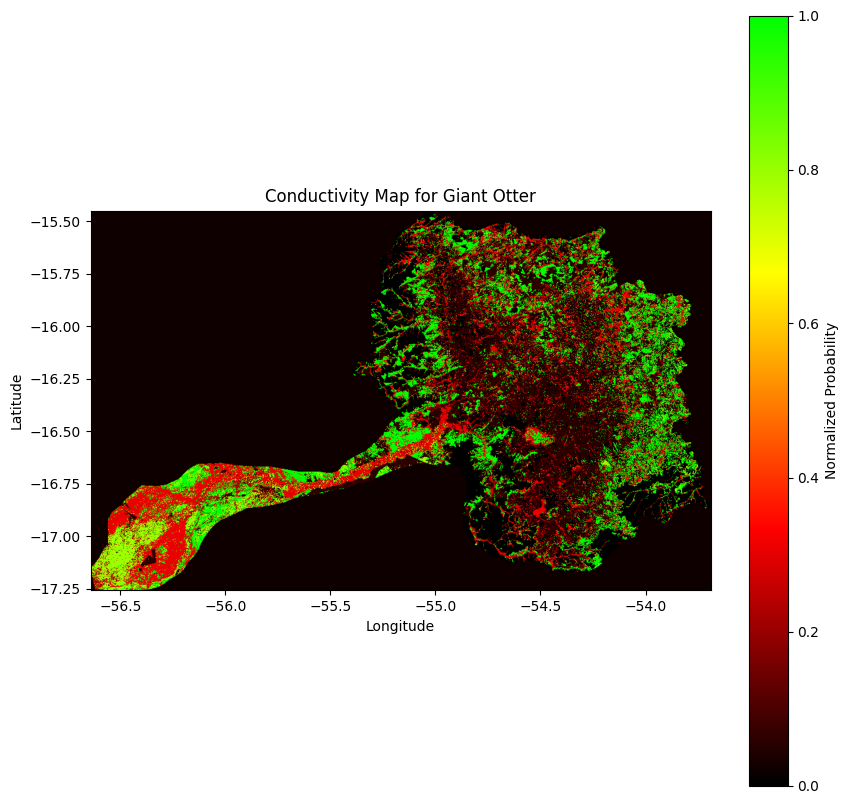

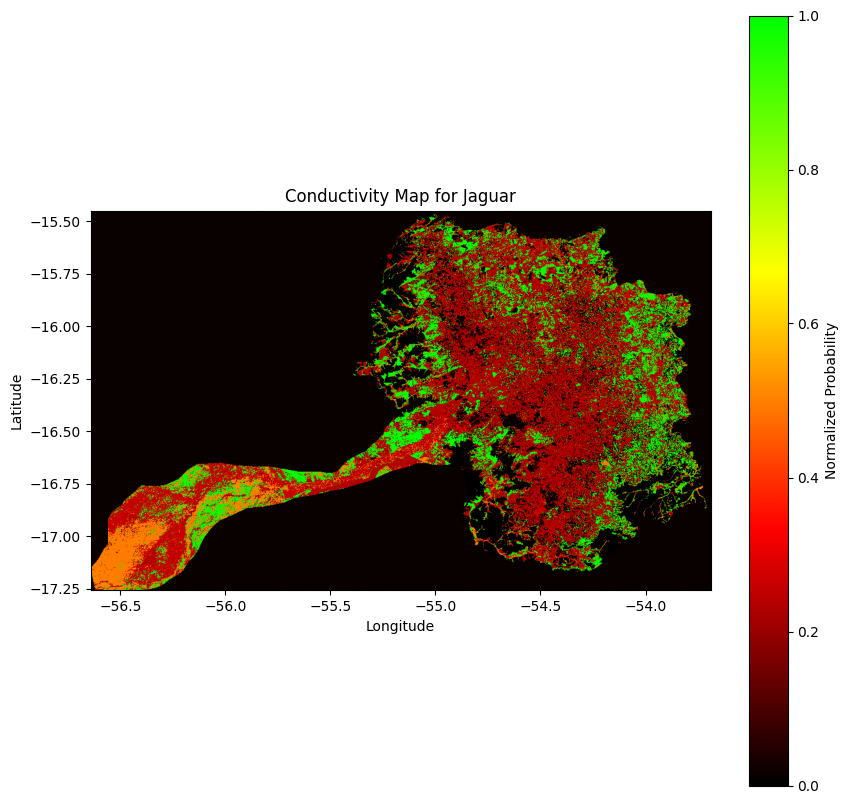

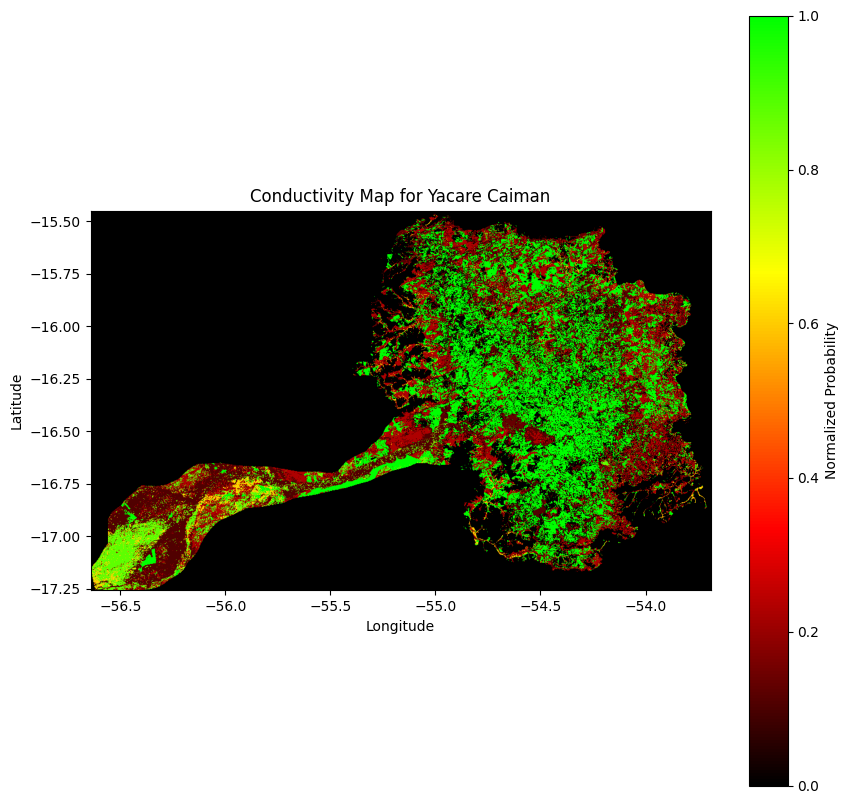

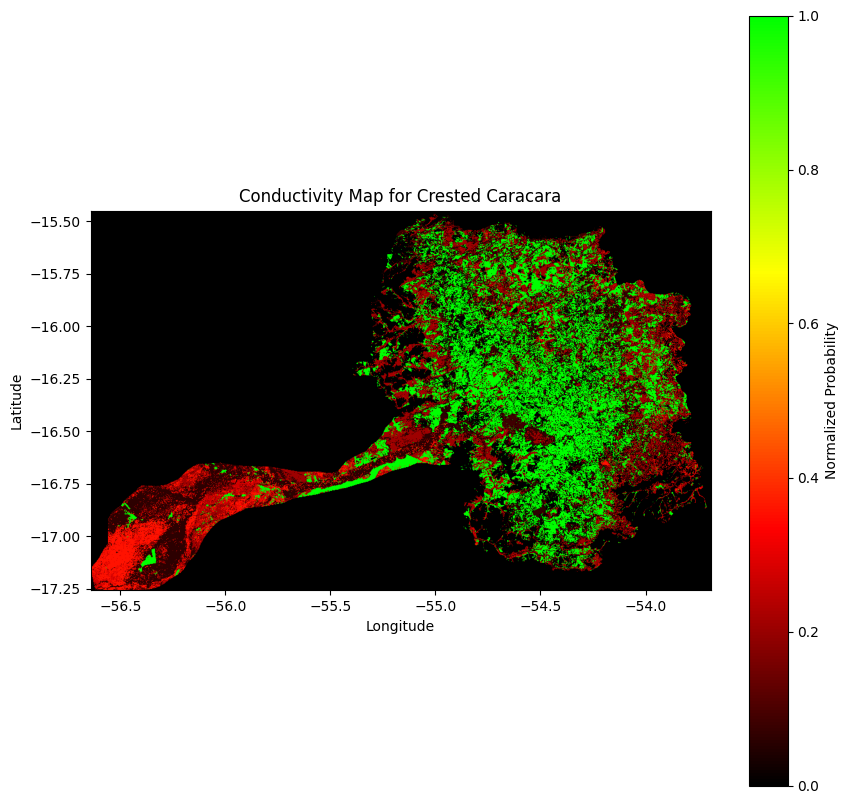

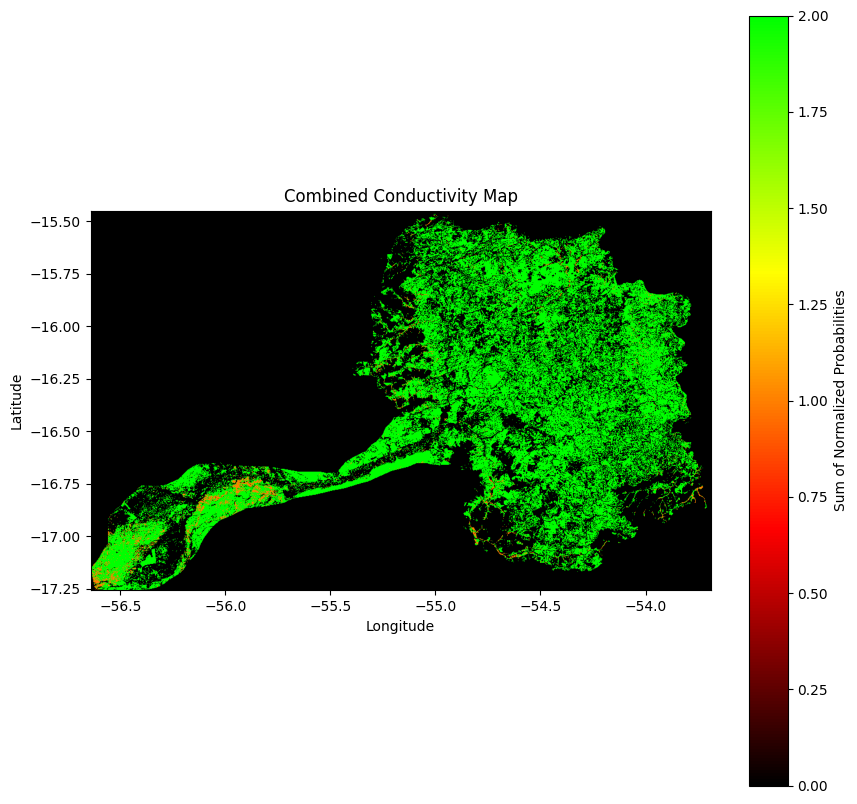

Visualizations for all conductivity maps generated successfully.


In [10]:
# Block 6: Visualize Conductivity Maps
# This section generates visualizations for each species' conductivity map and the combined map.
# A custom colormap (black-red-yellow-green) is used, and maps are plotted with spatial extents matching the 1985 São Lourenço map.
# Each plot is saved as a PNG file for inspection.

# Custom colormap for visualization (black -> red -> yellow -> green)
colors = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0)]
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Get study area bounds from a sample map (e.g., 1985.tif) for consistent extent
sample_map = "/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1985.tif"
with rasterio.open(sample_map) as src:
    bounds = src.bounds  # (min_lon, min_lat, max_lon, max_lat)

# Visualize individual conductivity maps
tiff_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('_conductivity.tif') and 'combined' not in f]
for tiff_file in tiff_files:
    species_name = tiff_file.replace('_conductivity.tif', '').replace('_', ' ').title()
    with rasterio.open(os.path.join(OUTPUT_DIR, tiff_file)) as src:
        raster = src.read(1)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(raster, cmap=cmap, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top], vmin=0, vmax=1)
    plt.colorbar(im, ax=ax, label='Normalized Probability')
    ax.set_title(f'Conductivity Map for {species_name}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.savefig(os.path.join(OUTPUT_DIR, f'{species_name.replace(" ", "_").lower()}_conductivity.png'))
    plt.show()

# Visualize combined conductivity map
combined_file = os.path.join(OUTPUT_DIR, 'combined_conductivity.tif')
if os.path.exists(combined_file):
    with rasterio.open(combined_file) as src:
        combined_raster = src.read(1)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(combined_raster, cmap=cmap, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    plt.colorbar(im, ax=ax, label='Sum of Normalized Probabilities')
    ax.set_title('Combined Conductivity Map')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.savefig(os.path.join(OUTPUT_DIR, 'combined_conductivity.png'))
    plt.show()

print("Visualizations for all conductivity maps generated successfully.")